In [16]:
import sys, os, datetime
sys.path.append("../../../")

from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

import brownie

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [18]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [19]:
ankreth = "0xA96A65c051bF88B4095Ee1f2451C2A9d43F53Ae2"
# cvxcrv_f = "0x9D0464996170c6B9e75eED71c68B99dDEDf279e8"

In [20]:
pool_contract_addr = ankreth

In [21]:
pool_contract = init_contract(contract_addr=pool_contract_addr)
pool_info = pool_contract.info()

initial_A = pool_contract.initial_A()
initial_A_time = pool_contract.initial_A_time()
A = pool_contract.A()
A_precise = pool_contract.A_precise()
A_precision = int(A_precise/A)

print(f"pool param details:")
print(f"initial_A: {initial_A}")
print(f"initial_A_time: {initial_A_time}")
print(f"A: {A}")
print(f"A_precise: {A_precise}")
print(f"A_precision: {A_precision}")

  @title ETH/ankrETH StableSwap
  @author Curve.Fi

pool param details:
initial_A: 1000
initial_A_time: 0
A: 10
A_precise: 1000
A_precision: 100


In [22]:
coin_addr = pool_contract.coins(0)
if coin_addr == "0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE":
    coin_0 = "ETH"
else:
    coin_0 = init_contract(coin_addr).name()

coin_addr = pool_contract.coins(1)
if coin_addr == "0xEeeeeEeeeEeEeeEeEeEeeEEEeeeeEeeeeeeeEEeE":
    coin_1 = "ETH"
else:
    coin_1 = init_contract(coin_addr).name()

print(coin_0, ',', coin_1)

ETH , Ankr ETH2 Reward Bearing Certificate


In [24]:
def get_peg_from_block(
    block_number_start: int, 
    pool_contract: brownie.Contract, 
    block_steps: int = 10000
) -> pd.DataFrame:

    current_block = brownie.web3.eth.block_number
    blocks_to_calculate = list(range(block_number_start, current_block, block_steps))
    blocks_to_calculate.append(current_block)

    data = {
        'timestamp': [],
        'block_number': [],
        'coin_0_perc': [],
        'coin_1_perc': [],
        'peg_ratio': [],
        "swap_rate_0_to_1": [],
        "swap_rate_1_to_0": [],
    }

    for block_number in blocks_to_calculate:

        block_details = brownie.web3.eth.get_block(block_number)
        block_time = datetime.datetime.fromtimestamp(block_details['timestamp'])

        try:
            pool_balances = pool_contract.get_balances(block_identifier=block_number)
        except ValueError:
            continue
        except:  # old vyper contracts did not have get_balances method
            pool_balances_0 = pool_contract.balances(0, block_identifier=block_number)
            pool_balances_1 = pool_contract.balances(1, block_identifier=block_number)

            swap_rate_1_to_0 = round(pool_contract.get_dy(1, 0, 1e18) * 1e-18, 4)
            swap_rate_0_to_1 = round(pool_contract.get_dy(1, 0, 1e18) * 1e-18, 4)

            pool_balances = (pool_balances_0, pool_balances_1)

        total_coins = (pool_balances[1]+pool_balances[0])

        coin_0_perc = round(pool_balances[0]/total_coins * 100, 2)
        coin_1_perc = round(pool_balances[1]/total_coins * 100, 2)

        peg_ratio = round(min(coin_0_perc, coin_1_perc) / max(coin_0_perc, coin_1_perc), 2)

        data['timestamp'].append(block_time)
        data['block_number'].append(block_number)
        data['coin_0_perc'].append(coin_0_perc)
        data['coin_1_perc'].append(coin_1_perc)
        data['peg_ratio'].append(peg_ratio)
        data['swap_rate_1_to_0'].append(swap_rate_1_to_0)
        data['swap_rate_0_to_1'].append(swap_rate_0_to_1)

    df_data = pd.DataFrame(data)

    return df_data.set_index('timestamp')


In [25]:
df_pool_peg = get_peg_from_block(block_number_start=13022595, pool_contract=pool_contract, block_steps=5000)

bar plot

In [26]:
plot_start_date = pd.Timestamp("2021-09-01")
df_plot = df_pool_peg[df_pool_peg.index > plot_start_date]
df_plot.reset_index(inplace=True)

In [27]:
df_plot

,timestamp,block_number,coin_0_perc,coin_1_perc,peg_ratio,swap_rate_0_to_1,swap_rate_1_to_0
0,2021-09-01 06:15:49,13137595,29.11,70.89,0.41,0.9473,0.9473
1,2021-09-02 00:57:38,13142595,29.11,70.89,0.41,0.9473,0.9473
2,2021-09-02 19:21:48,13147595,29.79,70.21,0.42,0.9473,0.9473
3,2021-09-03 13:56:34,13152595,29.41,70.59,0.42,0.9473,0.9473
4,2021-09-04 08:26:16,13157595,29.29,70.71,0.41,0.9473,0.9473
5,2021-09-05 02:56:35,13162595,29.33,70.67,0.42,0.9473,0.9473
6,2021-09-05 21:31:36,13167595,29.31,70.69,0.41,0.9473,0.9473
7,2021-09-06 16:03:46,13172595,28.71,71.29,0.40,0.9473,0.9473
8,2021-09-07 10:34:28,13177595,28.70,71.30,0.40,0.9473,0.9473
9,2021-09-08 05:14:14,13182595,28.77,71.23,0.40,0.9473,0.9473


In [28]:
bribe_tx = pd.Timestamp("2021-09-19 19:41:48", tz="utc")
bribe_tx

Timestamp('2021-09-19 19:41:48+0000', tz='UTC')

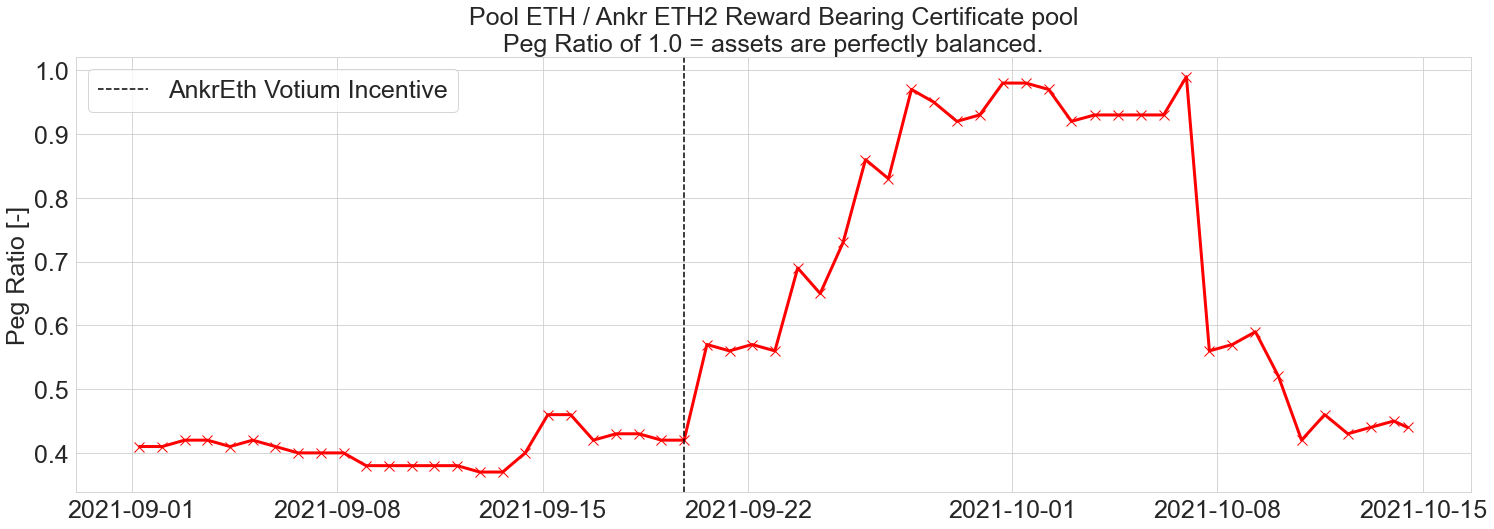

In [29]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

peg_ratio_explanation = "Peg Ratio of 1.0 = assets are perfectly balanced."
ax.plot(df_plot.timestamp, df_plot.peg_ratio, 'rx-', lw=3, ms=10)

ax.axvline(x=bribe_tx, label="AnkrEth Votium Incentive", color='k', ls='--')

ax.set_ylabel("")
ax.set_ylabel("Peg Ratio [-]", fontsize=25)
ax.set_title(f"Pool {coin_0} / {coin_1} pool\n{peg_ratio_explanation}", fontsize=25);
ax.tick_params(axis='both', which='major', labelsize=25);

ax.legend(fontsize=25)

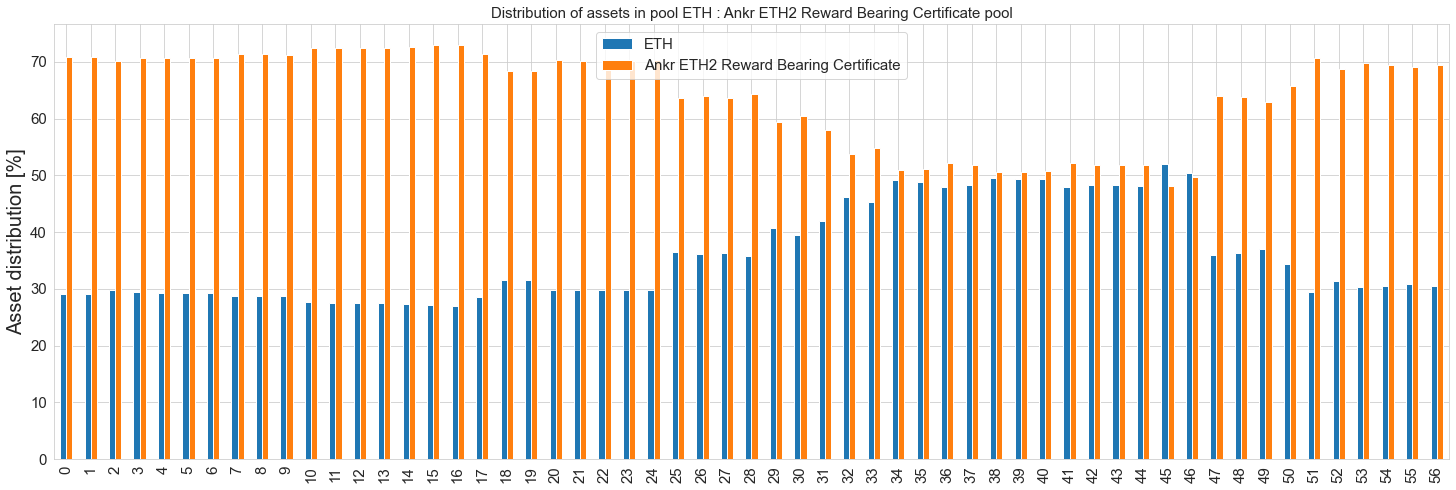

In [30]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

df_plot[["coin_0_perc", "coin_1_perc"]].plot(ax=ax, kind="bar")

# ax.axvline(x=A, label="Current A", color='k', ls='--')

ax.set_ylabel("Asset distribution [%]", fontsize=20)
ax.set_title(f"Distribution of assets in pool {coin_0} : {coin_1} pool", fontsize=15);
ax.tick_params(axis='both', which='major', labelsize=15);

ax.legend([coin_0, coin_1], fontsize=15);

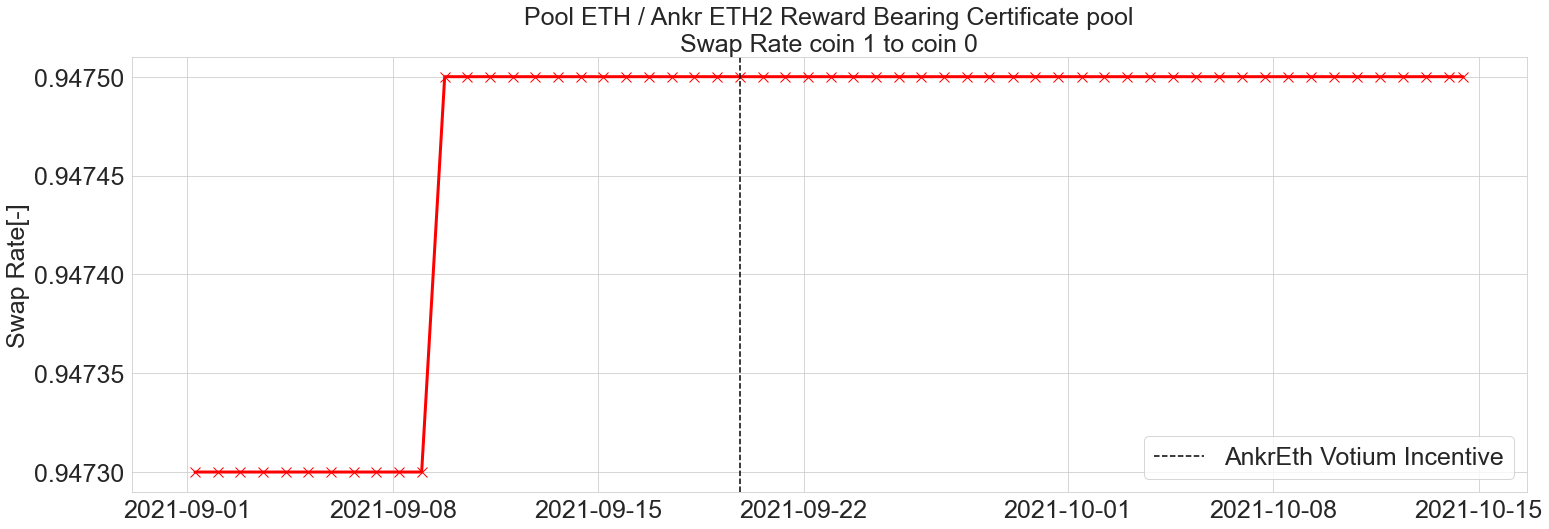

In [31]:
fig, ax = plt.subplots(1,1, figsize=(25, 8))

plot_explanation = "Swap Rate coin 1 to coin 0"
ax.plot(df_plot.timestamp, df_plot.swap_rate_1_to_0, 'rx-', lw=3, ms=10)

ax.axvline(x=bribe_tx, label="AnkrEth Votium Incentive", color='k', ls='--')

ax.set_ylabel("")
ax.set_ylabel("Swap Rate[-]", fontsize=25)
ax.set_title(f"Pool {coin_0} / {coin_1} pool\n{plot_explanation}", fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.legend(fontsize=25)

disconnect

In [ ]:
brownie.network.disconnect()